# Apache Kafka Streaming Analytics
### One Broker Setup
<br>
<hr>

#### Component: Consumer
In this notebook Apache Kafka is going to be used and analyzed with reference to the streaming performance using the twitter dataset.

In this case, we are going to use only one **Kafka Broker** that streams the data to the **Kafka Consumer**.

In [ ]:
# Install the Python Client for Apache Kafka
!pip install confluent-kafka

In [1]:
# Load dependencies and set constants
import matplotlib.pyplot as plt
import json
import time

from confluent_kafka import Consumer, KafkaError

DATASET_SIZE_IN_MB = 10
DATASET_SIZE_IN_MSGS = 14485

CONSUMER_GROUP_ID = "twitter-consumers"
KAFKA_TOPIC_TWITTER = "twitter-stream"

def get_kafka_stats(json_stats_bytes: bytes):
    """ Callback for the Apache Kafka Consumer Configuration which 
    requests performance metrics / statistics from Kafka. 
    
    :param json_stats_bytes: The JSON statistics data in bytes
    """
    # Decode the bytes into a python dictionary representing the JSON
    stats = json.loads(json_stats_bytes)
    # TODO: Check if we can actually use those statistics. If so, uncomment them in the consumer config

### Reminder: Running Kafka Architecture required
The following cells assume a running Apache Kafka Environment.
<hr>
<br>

Furthermore, as we are using the **Consumer** component here, we have to make sure to start the consumer first before we start the Producer to ensure a performance measurement under realistic circumstances.

In [2]:
# Create Kafka Consumer
consumer_config = {
    "bootstrap.servers": "localhost:9092",
    "group.id": CONSUMER_GROUP_ID,
    "client.id": "client-1",
#     "stats_cb": get_kafka_stats,
#     "statistics.interval.ms": 20,
#     'api.version.request': True,
    "enable.auto.commit": True,
    "session.timeout.ms": 6000,
    "default.topic.config": {"auto.offset.reset": "smallest"}
}
c = Consumer(consumer_config)

In [ ]:
# This is left for testing, for benchmark see below
c.subscribe([KAFKA_TOPIC_TWITTER])

msg_count = 0
latency_sum = 0
latencies = []
try:
    while True:
            msg = c.poll(0)
            
            if msg is None:
                continue
            elif not msg.error():
                msg_count += 1
                timestamp_type, timestamp = msg.timestamp()
                latency = (time.time() * 1000) - timestamp
                
                latency_sum += latency
                latencies.append(latency)
                
                # Display the received tweet
                #tweet_json = json.loads(msg.value())
                #print(json.dumps(tweet_json, indent=4, ensure_ascii=False, sort_keys=True))
            elif msg.error().code() == KafkaError._PARTITION_EOF:
                print("End of partition reached {}/{}".format(msg.topic(), msg.partition()))
            else:
                print("Error occured: {}".format(msg.error().str()))
except KeyBoardInterrupt:
    pass
finally:
    print("Received {} messages".format(msg_count))
    print("Average latency: {}".format(latency_sum / msg_count))
    c.close()

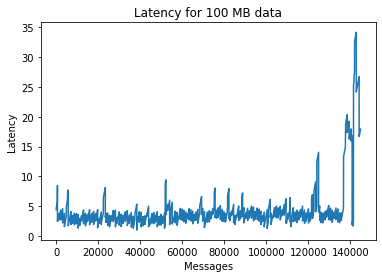

In [34]:
# Plot latency results
fig = plt.figure()
ax = plt.axes()

xs = [i for i in range(msg_count)]
ys = latencies

ax.plot(xs, ys)
ax.set_xlabel("Messages")
ax.set_ylabel("Latency")
ax.set_title("Latency for 100 MB data")
fig.show()

In [44]:
def benchmark(data_vol: int = 1000, exec_count: int = 10):
    """ Executes a latency benchmark procedure, e.g. the elapsed time between storing 
        a message in the logs at the Broker side (LogAppendTime) and receiving / consuming it 
        on the Consumer side. To get meaningful results, the benchmark procedure is repeated
        exec_count times.
        Default is ~ 1GB per execution, while executing 10 times.

        :param data_vol: Amount of data to expect per execution, given in MB. As the dataset is
                         10 MB large, data_vol % 10 = 0 should be true for the given argument.
        :param exec_count: Amount of times to repeat the benchmark procedure
    """
    print("Executing latency benchmark. Waiting for Producer sending data ...")
    
    latency_results = []
    benchmark_msg_count = DATASET_SIZE_IN_MSGS * (data_vol / DATASET_SIZE_IN_MB)
    
    c.subscribe([KAFKA_TOPIC_TWITTER])
    for execution in range(exec_count):
        latencies = []
        msg_counter = 0
        
        while msg_counter < benchmark_msg_count:
            msg = c.poll(0)
            
            if msg is None:
                continue
            elif not msg.error():
                msg_counter += 1
                latency = (time.time() * 1000) - msg.timestamp()[1]
                latencies.append(latency)
            elif msg.error().code() == KafkaError._PARTITION_EOF:
                print("End of partition reached {}/{}".format(msg.topic(), msg.partition()))
            else:
                print("Error occured: {}".format(msg.error().str()))
        
        latency_results.append(latencies)
    
    print("Benchmark procedure finished. Visualizing the results ...")
    for exec_count, latencies in enumerate(latency_results):
        latencies.sort()
        
        # Percentiles
        p50_idx = int(len(latencies) * 50.0 / 100.0)
        p75_idx = int(len(latencies) * 75.0 / 100.0)
        p90_idx = int(len(latencies) * 90.0 / 100.0)
        p95_idx = int(len(latencies) * 95.0 / 100.0)
        p99_idx = int(len(latencies) * 99.0 / 100.0)
        
        p50 = latencies[p50_idx]
        p75 = latencies[p75_idx]
        p90 = latencies[p90_idx]
        p95 = latencies[p95_idx]
        p99 = latencies[p99_idx]
        
        fig = plt.figure(figsize=(12, 6), dpi=90)
        ax = plt.axes()
        
        # Plot the ascendingly sorted latencies
        xs = [i for i in range(1, msg_counter+1)]
        ys = latencies
        ax.plot(xs, ys)
        
        # Set Percentile labels and visualize them by dashed lines
        ax.set_xticks([p50_idx, p75_idx, p90_idx, p95_idx, p99_idx])
        ax.set_xticklabels(["50%", "75%", "90%", "95%", "99%"])
        ax.grid(axis="x", color="green", alpha=.4, linewidth=2, linestyle=":")
        
        ax.set_ylabel("Latency (ms)", fontsize=12)
        ax.set_title("Benchmark {0}: Latencies ({1} MB)".format(exec_count+1, data_vol))
        
        fig.show()

Executing latency benchmark. Waiting for Producer sending data ...
Benchmark procedure finished. Visualizing the results ...


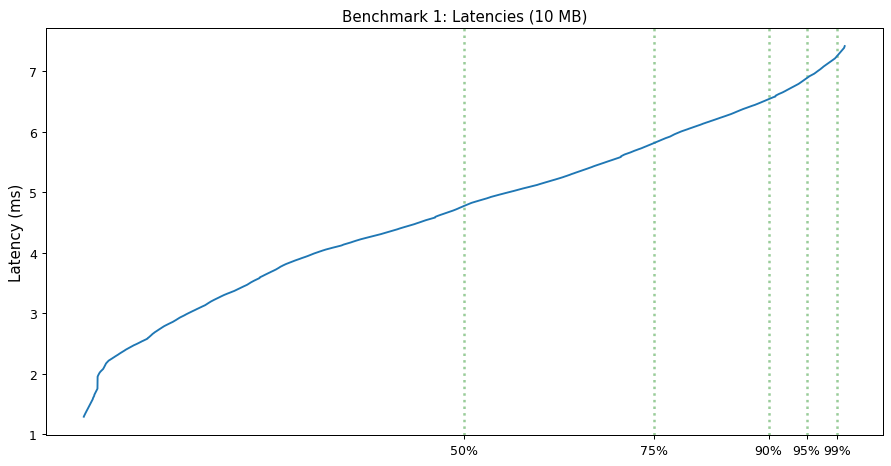

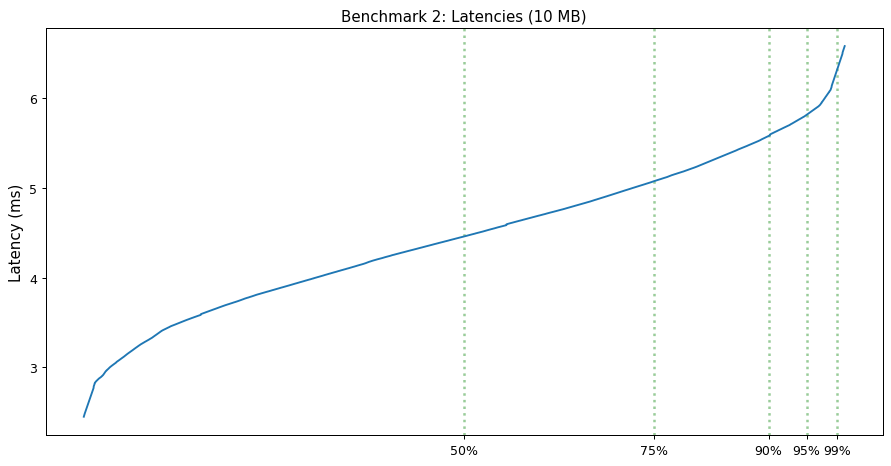

In [45]:
# Execute the benchmark
benchmark(data_vol=10, exec_count=2)